In [1]:
from scripts.data_genertion.consts import *
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from scripts.data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df[[SENSE_TYPE, 'sense_intron', 'sense_exon', 'sense_utr', SENSE_START, CANONICAL_GENE]]

,sense_type,sense_intron,sense_exon,sense_utr,sense_start,Canonical Gene Name
0,intron,1,0,0,41212,KRAS
1,intron,1,0,0,23686,KRAS
2,intron,1,0,0,43363,KRAS
3,intron,1,0,0,23680,KRAS
4,intron,1,0,0,41168,KRAS
...,...,...,...,...,...,...
34760,intron,1,0,0,7827,APOL1
34761,intron,1,0,0,8250,APOL1
34762,intron,1,0,0,8335,APOL1
34763,utr,0,1,1,13848,APOL1


In [5]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']

In [6]:
from scripts.data_genertion.consts import *


class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in ['md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                           'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600'
                           ]:
                self.hybridization.append(feature)
            # if feature in [SENSE_TYPE]:
            #     self.one_hot.append(feature)
            if feature in ['at_skew', 'gc_content', 'entropy', 'gc_skew',
                           'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold',
                           'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score',
                           'poly_pyrimidine_stretch', 'normalized_start', 'sense_exon', 'sense_intron', 'sense_utr']:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold


main_df.columns

Index(['index', 'ASO_volume(nM)', 'Canonical Gene Name', 'Cell line organism',
       'Cell_line', 'Chemical_Pattern', 'Density(cells_per_well)', 'ISIS',
       'Inhibition(%)', 'Linkage', 'Linkage_Location', 'Location',
       'Location_div_by_length', 'Location_in_sequence', 'Modification',
       'Primer_probe_set', 'Sequence', 'Target_gene', 'Transcript',
       'Transfection', 'Treatment_Period(hours)', 'at_rich_region_score',
       'at_skew', 'cell_line_uniform',
       'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Trueon_target_energy_max600',

In [7]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [8]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'sense_start_from_end')

In [9]:
import numpy as np
import pandas as pd

first_filtered = main_df.copy()

first_filtered = first_filtered[first_filtered['Cell line organism'] == 'human']
# filtered = filtered[filtered[CANONICAL_GENE] == 'MALAT1']
first_filtered = first_filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.01
first_filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - first_filtered[INHIBITION] / 100)
first_filtered = first_filtered[~first_filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications;
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]
# first_filtered = first_filtered[~((first_filtered[CELL_LINE] == 'A431')
#                                   & (first_filtered[CANONICAL_GENE] == 'SOD1'))] # (Kind of) Scanning modifications

mean_metric = 'log_inhibition'
# mean_metric = INHIBITION

# Ensure you remove only the columns you don't want to group by
# cols_except_inhibition = [c for c in first_filtered.columns
#                           if c not in [INHIBITION, mean_metric, 'index']]

# Group by all remaining columns and average log_inhibition
collapsed = (
    first_filtered
    .groupby(['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN], as_index=False)[mean_metric]
    .mean()
)

# first_filtered['mean_inhibition'] = first_filtered.groupby('ISIS')[mean_metric].transform('mean')
# first_filtered = first_filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: first_filtered['mean_inhibition']}).drop(
#     columns='mean_inhibition')

In [10]:
collapsed

,ISIS,ASO_volume(nM),Treatment_Period(hours),Density(cells_per_well),Chemical_Pattern,log_inhibition
0,76577.0,4000.0,48.0,10000.0,CCCddddddddddCCC,0.462035
1,146143.0,187.5,16.0,20000.0,MMMMMddddddddddMMMMM,0.051293
2,146143.0,750.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.116534
3,146143.0,3000.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.693147
4,146143.0,4000.0,24.0,20000.0,MMMMMddddddddddMMMMM,0.713350
...,...,...,...,...,...,...
23189,70001072.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.347074
23190,70001081.0,5000.0,96.0,2000.0,LLLLdddddddddLLLL,1.108663
23191,70001101.0,5000.0,96.0,15000.0,LLLddddddddddLLL,1.386294
23192,70001102.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.272966


In [11]:
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()
filtered = first_filtered.copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
filtered['correct_log_inhibition2'] = li / (filtered[VOLUME] * 0.0000601 + 0.537)
# filtered['correct_log_inhibition'] = li


features_obj = Features(filtered.columns)
features_obj.hybridization = ['exp_ps_hybr']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
    TREATMENT_PERIOD,
    # 'log_volume',
    # DENSITY_UPDATED
]
print(features_obj.one_hot)
for feature in features_obj.one_hot:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()

one_hot_features = []
for one_hot_feature in features_obj.one_hot:
    one_hot_features.append(
        [feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
flat_one_hot_encoded_features = [feature for sublist in one_hot_features for feature in sublist]
# features = epi_features
features = epi_features + features + flat_one_hot_encoded_features


[]


In [12]:
filtered_original = filtered

ALL_CELL_LINES = filtered_original[CELL_LINE].unique()
only_cancer = filtered_original[
    # (~((filtered_original[CELL_LINE] == 'HepG2') & (filtered_original[TRANSFECTION].str.contains('Lipo')))) &
    (filtered_original[CELL_LINE] != 'HepG2')  # experiment settings too different
    & (filtered_original[CELL_LINE] != 'HepaRG')  # not similar to cancer
    & (filtered_original[CELL_LINE] != 'A-431')
    ]

Pearson r = -0.057, p = 1.62e-12
Spearman r = -0.063, p = 6.96e-15
Fit: y = -3.601x + 40.856


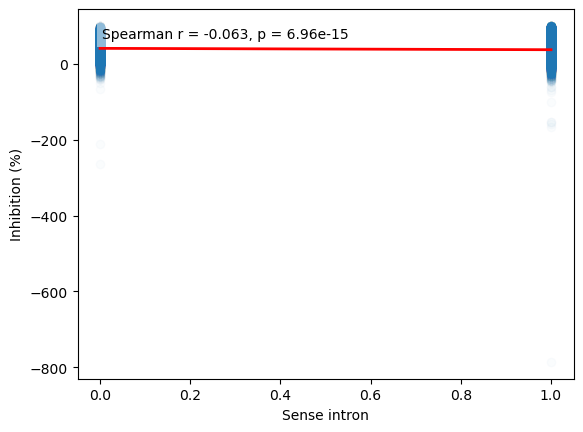

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

x = only_cancer['sense_intron']
y = only_cancer[INHIBITION]

plt.clf()
plt.scatter(x, y, alpha=0.02)
plt.xlabel('Sense intron')
plt.ylabel('Inhibition (%)')

# === toggle fit type ===
use_quadratic = False   # set False for linear

xs = np.linspace(np.nanmin(x), np.nanmax(x), 500)

if use_quadratic:
    # Quadratic fit
    a, b, c = np.polyfit(x, y, 2)
    ys = a*xs**2 + b*xs + c
    y_pred = a*x**2 + b*x + c
    fit_label = f"y = {a:.3f}x² + {b:.3f}x + {c:.3f}"
else:
    # Linear fit
    m, b = np.polyfit(x, y, 1)
    ys = m*xs + b
    y_pred = m*x + b
    fit_label = f"y = {m:.3f}x + {b:.3f}"

plt.plot(xs, ys, color="red", linewidth=2)

# Correlations
r_p, p_p = pearsonr(x, y)
r_s, p_s = spearmanr(x, y)

print(f"Pearson r = {r_p:.3f}, p = {p_p:.2e}")
print(f"Spearman r = {r_s:.3f}, p = {p_s:.2e}")
print("Fit:", fit_label)

# R²
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res/ss_tot

plt.text(0.05, 0.95,
         # f"R² = {r2:.3f}\n"
         f"Spearman r = {r_s:.3f}, p = {p_s:.2e}",
         transform=plt.gca().transAxes,
         ha="left", va="top",
         fontsize=10,
         bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))

plt.show()


Length       A431,           :  6541   Pearson unseen: 0.357 seen: 0.474 Spearman unseen: 0.384 Spearman seen 0.413
Model, best, random (54.48, 99.2, 46.14)
Length KARPAS-229,           :  972    Pearson unseen: 0.332 seen: 0.453 Spearman unseen: 0.345 Spearman seen 0.431
Model, best, random (47.2, 81.6, 31.08)
Length      A-431,           :  126    Pearson unseen: 0.254 seen: 0.434 Spearman unseen: 0.298 Spearman seen 0.410
Model, best, random (50.92, 72.22, 31.04)
Length      MM.1R,           :  3394   Pearson unseen: 0.369 seen: 0.495 Spearman unseen: 0.357 Spearman seen 0.480
Model, best, random (52.8, 92.82, 27.94)
Length  SK-MEL-28,           :  2836   Pearson unseen: 0.213 seen: 0.431 Spearman unseen: 0.173 Spearman seen 0.368
Model, best, random (56.34, 88.86, 37.42)
Length    SNU-449,           :  1119   Pearson unseen: 0.191 seen: 0.444 Spearman unseen: 0.226 Spearman seen 0.439
Model, best, random (67.6, 94.34, 56.6)
Length     HepaRG,           :  6608   Pearson unseen: 0.0

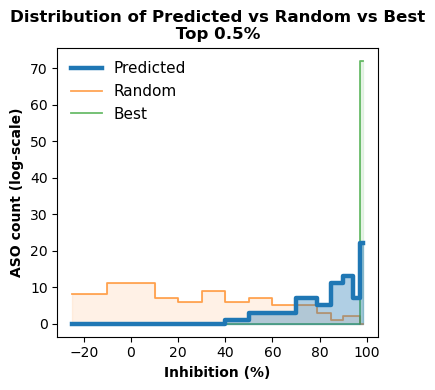

[(54.48, 99.2, 46.14), (47.2, 81.6, 31.08), (50.92, 72.22, 31.04), (52.8, 92.82, 27.94), (56.34, 88.86, 37.42), (67.6, 94.34, 56.6), (40.7, 95.64, 49.04), (74.146, 91.632, 74.252), (54.18, 96.7, 58.62)]
Total correlation: P:0.434 S:0.410
Spearman dict:  {'A431': 0.38391643837492795, 'KARPAS-229': 0.34461451318674885, 'A-431': 0.29758293317114953, 'MM.1R': 0.35678481391453903, 'SK-MEL-28': 0.17314361491822905, 'SNU-449': 0.2258739774822241, 'HepaRG': 0.04495694462616949, 'U251': 0.04449275376644238, 'HepG2': -0.024652035149971246}
Score dict:  {'A431': 0.17261806127259519, 'KARPAS-229': 0.39900474584053996, 'A-431': 0.6133923328013765, 'MM.1R': 0.38792023786354346, 'SK-MEL-28': 0.4407068188485292, 'SNU-449': 0.2924523367299007, 'HepaRG': 0.2623372748782159, 'U251': 0.3906976809645627, 'HepG2': 0.2956518838318242}


In [14]:
from scripts.Models.model_helpers import evaluate_top
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRanker
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

cell_lines = ALL_CELL_LINES
genes = only_cancer[CANONICAL_GENE].unique()

seed = 42
# model = RandomForestRegressor(n_jobs=-1)
model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed, n_jobs=-1)
# model = LinearRegression()
# model = LassoCV(cv=5)  # alpha = regularization strength

metric = 'correct_log_inhibition2'
# metric = 'log_inhibition'
# metric = INHIBITION

df_copy = only_cancer.copy()
gene = ""
top = []
spearman_dict = {}
score_dict = {}
for cell_line in cell_lines:
    # for gene in genes:
    if True:
        # missing_cell_line = only_cancer[(only_cancer[CELL_LINE] == cell_line) & (only_cancer[CANONICAL_GENE] == gene)]
        missing_cell_line = filtered_original[(filtered_original[CELL_LINE] == cell_line)]
        if len(missing_cell_line) < 100:
            continue

        # filtered = only_cancer[(only_cancer[CELL_LINE] != cell_line) & (only_cancer[CELL_LINE] != gene)]
        filtered = df_copy[(df_copy[CELL_LINE] != cell_line)].copy()


        # mean_metric = INHIBITION

        # keys = ['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN]
        #
        # agg_spec = {mean_metric: 'mean'}
        # agg_spec.update({c: 'first' for c in filtered.columns
        #                  if c not in set(keys + [mean_metric])})
        #
        # filtered = filtered.groupby(keys, as_index=False).agg(agg_spec)


        train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
        train['group_key'] = train[CELL_LINE].astype(str)
        # train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
        train = train.sort_values('group_key')
        group_train = train.groupby('group_key').size().tolist()

        X = train[features]
        # y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
        y = train[metric]

        # model = RandomForestRegressor(
        #     n_estimators=600,      # more trees → stabler
        #     max_depth=8,          # limit depth
        #     min_samples_leaf=15,   # larger leaves
        #     min_samples_split=20,  # stronger split guard
        #     max_features=0.3,      # more randomness per split
        #     bootstrap=True,
        #     max_samples=0.6,       # subsample rows (bagging)
        #     oob_score=True,        # quick gen-error check
        #     n_jobs=-1,
        #     random_state=seed
        # )
        # model = XGBRanker(objective='rank:pairwise')
        model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
        # model.fit(X.to_numpy(), y.to_numpy())

        predicted_unseen = model.predict(missing_cell_line[features].values)
        true_unseen = missing_cell_line[metric]

        predicted_seen = model.predict(filtered[features].values)
        true_seen = filtered[metric]

        corr, _ = pearsonr(predicted_unseen, true_unseen)
        corrs, _ = spearmanr(predicted_unseen, true_unseen)
        corr2, _ = pearsonr(predicted_seen, true_seen)
        corrs2, _ = spearmanr(predicted_seen, true_seen)

        print(
            f"Length {cell_line:>10}, {gene:>10}:  {len(missing_cell_line):<6d} Pearson unseen: {corr:.3f} seen: {corr2:.3f}"
            f" Spearman unseen: {corrs:.3f} Spearman seen {corrs2:.3f}")

        score = model.score(missing_cell_line[features].to_numpy(), missing_cell_line[metric].to_numpy())
        score_dict[cell_line] = score
        spearman_dict[cell_line] = corrs
        evaluated = evaluate_top(model, missing_cell_line, metric=metric, log_correction=log_correction, top_k=50,
                                features=features, plot=False)
        print("Model, best, random", evaluated)
        top.append(evaluated)
        # plt.scatter(predicted_unseen, true_unseen)
        # plt.show()

print("Shir plot")
evaluate_top(model, only_cancer, metric=metric, log_correction=log_correction, features=features, plot=True)

print(top)
train, test = train_test_split(only_cancer, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()
X = train[features]
y = train[metric]
model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
# model.fit(X.to_numpy(), y.to_numpy())

predicted = model.predict(only_cancer[features].values)
true = only_cancer[metric]

corrp, _ = pearsonr(predicted, true)
corrs, _ = spearmanr(predicted, true)

print(f"Total correlation: P:{corrp:.3f} S:{corrs:.3f}")
print("Spearman dict: ", spearman_dict)
print("Score dict: ", score_dict)

/tmp/ipykernel_3583004/993963422.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, fontsize=10)


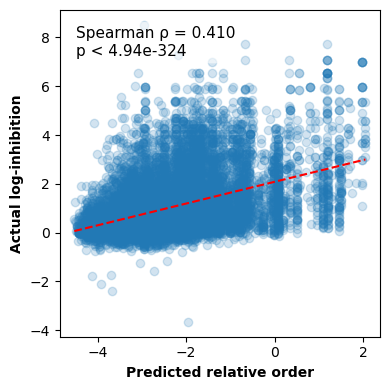

In [19]:
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt

corrs, pval = spearmanr(predicted, true)

# If pval is exactly 0, replace with smallest positive float
if pval == 0.0:
    pval_display = np.nextafter(0, 1)
else:
    pval_display = pval

fig, ax = plt.subplots(figsize=(4, 4), facecolor="none")
fig.patch.set_alpha(0.0)
ax.set_facecolor("none")

ax.scatter(predicted, true, alpha=0.2)

# Best-fit line (linear regression)
coef = np.polyfit(predicted, true, 1)
poly1d_fn = np.poly1d(coef)
x_line = np.linspace(np.min(predicted), np.max(predicted), 200)
ax.plot(x_line, poly1d_fn(x_line), 'r--', lw=1.5)

# Bold labels
ax.set_xlabel("Predicted relative order", fontweight="bold")
ax.set_ylabel("Actual log-inhibition", fontweight="bold")

# Correlation text with box
ax.text(0.05, 0.95,
        f"Spearman ρ = {corrs:.3f}\np < {pval_display:.2e}",
        transform=ax.transAxes,
        va="top", ha="left", fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                  edgecolor="none", alpha=0.6))

ax.legend(frameon=False, fontsize=10)

fig.tight_layout()
plt.show()


In [ ]:
filtered_original = filtered

print(filtered_original[CELL_LINE].unique())
# only_cancer = filtered_original
only_cancer = filtered_original[filtered_original[CELL_LINE] != 'A-431']

# only_cancer = filtered[(filtered_original[CELL_LINE] == 'HepG2')
#                        | (filtered_original[CELL_LINE] == 'HepaRG')
#                           ]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from scripts.Models.model_helpers import evaluate_top
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRanker
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

cell_lines = only_cancer[CELL_LINE].unique()
genes = only_cancer[CANONICAL_GENE].unique()

seed = 42
# model = RandomForestRegressor(
#     n_estimators=600,      # more trees → stabler
#     max_depth=8,          # limit depth
#     min_samples_leaf=15,   # larger leaves
#     min_samples_split=20,  # stronger split guard
#     max_features=0.3,      # more randomness per split
#     bootstrap=True,
#     max_samples=0.6,       # subsample rows (bagging)
#     oob_score=True,        # quick gen-error check
#     n_jobs=-1,
#     random_state=seed
# )
# model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed, n_jobs=-1)
model = LinearRegression()

metric = 'correct_log_inhibition'

gene = ''
top = []
for cell_line in cell_lines:
    # for gene in genes:
    if True:
        # missing_cell_line = only_cancer[(only_cancer[CELL_LINE] == cell_line) & (only_cancer[CANONICAL_GENE] == gene)]
        missing_cell_line = only_cancer[(only_cancer[CELL_LINE] == cell_line)]
        if len(missing_cell_line) < 100:
            continue

        # filtered = only_cancer[(only_cancer[CELL_LINE] != cell_line) & (only_cancer[CELL_LINE] != gene)]
        filtered = only_cancer[(only_cancer[CELL_LINE] != cell_line)]
        train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
        train['group_key'] = train[CELL_LINE].astype(str)
        # train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
        train = train.sort_values('group_key')
        group_train = train.groupby('group_key').size().tolist()

        # metric = 'log_inhibition'
        # metric = INHIBITION

        X = train[features]
        # y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
        y = train[metric]

        # model = RandomForestRegressor(
        #     n_estimators=600,      # more trees → stabler
        #     max_depth=8,          # limit depth
        #     min_samples_leaf=15,   # larger leaves
        #     min_samples_split=20,  # stronger split guard
        #     max_features=0.3,      # more randomness per split
        #     bootstrap=True,
        #     max_samples=0.6,       # subsample rows (bagging)
        #     oob_score=True,        # quick gen-error check
        #     n_jobs=-1,
        #     random_state=seed
        # )
        # model = XGBRanker(objective='rank:pairwise')
        # model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
        model.fit(X.to_numpy(), y.to_numpy())

        predicted_unseen = model.predict(missing_cell_line[features].values)
        true_unseen = missing_cell_line[metric]

        predicted_seen = model.predict(filtered[features].values)
        true_seen = filtered[metric]

        top.append(evaluate_top(model, missing_cell_line, metric=metric, log_correction=log_correction, top_k=50,
                                features=features))

        corr, _ = pearsonr(predicted_unseen, true_unseen)
        corrs, _ = spearmanr(predicted_unseen, true_unseen)
        corr2, _ = pearsonr(predicted_seen, true_seen)
        corrs2, _ = spearmanr(predicted_seen, true_seen)

        print(
            f"Length {cell_line:>10}, {gene:>10}:  {len(missing_cell_line):<6d} Pearson unseen: {corr:.3f} seen: {corr2:.3f}"
            f" Spearman unseen: {corrs:.3f} Spearman seen {corrs2:.3f}")

        # plt.scatter(predicted_unseen, true_unseen)
        # plt.show()

print(top)
train, test = train_test_split(only_cancer, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()
metric = 'correct_log_inhibition'
X = train[features]
y = train[metric]
# model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
model.fit(X.to_numpy(), y.to_numpy())

predicted = model.predict(only_cancer[features].values)
true = only_cancer[metric]

corrp, _ = pearsonr(predicted, true)
corrs, _ = spearmanr(predicted, true)

print(f"Total correlation: P:{corrp:.3f} S:{corrs:.3f}")


In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
# for cell_line in cell_lines:
for cell_line in cell_lines:
    cell_line_mask = filtered[CELL_LINE] == cell_line
    print(f"cell-line:{cell_line}, length:{cell_line_mask.sum()} ", cell_line)
    print(metric)

    for gene in filtered[cell_line_mask][CANONICAL_GENE].unique():
        hepa_mask = cell_line_mask & (filtered[CANONICAL_GENE] == gene)
        print(f"gene-{gene} length: {hepa_mask.sum()}")
        # for f in ['sense_exon', 'sense_intron', 'sense_utr']:
        for f in ['NA']:
            # hep_pred = filtered[hepa_mask][f].to_numpy()
            # print(f"{f}: {filtered[hepa_mask][f].sum()} / {hepa_mask.sum()}")
            hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
            hepa_truth = filtered[hepa_mask][metric]
            p_hepa, pp_value = pearsonr(hepa_truth, hep_pred)
            s_hepa, sp_value = spearmanr(hepa_truth, hep_pred)
            print(f"P:{p_hepa:.2}, p-value: {pp_value:.2}")
            print(f"S:{s_hepa:.2} , p-value: {sp_value:.2}")

for feature in features:
    # EXAMPLE = 'GGCATATGCAGATAATGTTC'

    # malat_mask = filtered[CELL_LINE] == 'U251'

    # malat_mask = filtered[CANONICAL_GENE] == "HSD17B13"
    malat_mask = filtered[CANONICAL_GENE] == "MALAT1"
    # example_mask = (filtered[CANONICAL_GENE] == "MALAT1") & (filtered[SEQUENCE] == EXAMPLE)
    malat_pred = model.predict(filtered[malat_mask][features].to_numpy())
    print(metric)
    malat_truth = filtered[malat_mask][metric]
    p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
    s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])

    plt.scatter(filtered[malat_mask][feature], malat_truth)
    # example_df = filtered.loc[example_mask, :].copy()
    # plt.scatter(example_df[feature], malat_truth[example_mask], color='orange')
    plt.scatter(filtered[malat_mask][feature], malat_truth, color='blue', alpha=0.05)
    plt.xlabel(feature)
    plt.ylabel(metric)
    print("Feature: ", feature)
    print(f"P:{p_hepa:.2} p-value {pp_value:.2}")
    print(f"S:{s_hepa:.2} p-value {sp_value:.2}")
    plt.show()

p_hepa, _ = pearsonr(malat_truth, malat_pred)
s_hepa, _ = spearmanr(malat_truth, malat_pred)
print("P: ", p_hepa)
print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, p_value_ptest = pearsonr(y_test, test_pred)
s_test, p_value_stest = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)
print("PvaluePtest: ", p_value_ptest)
print("PValueStest: ", p_value_stest)

# scatter plot
# plt.scatter(test_pred, y_test, alpha=0.2)
plt.scatter(malat_pred, malat_truth, alpha=0.2)

# least‑squares regression line
# slope, intercept = np.polyfit(test_pred, y_test, 1)
# x = np.linspace(test_pred.min(), test_pred.max(), 100)
# plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel(metric)
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [ ]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [ ]:
from scripts.Models.model_helpers import log_inhibition_to_regular


def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


# def correction(df):
#     return (df['log_volume'])

# def correction(df):
#     return (df[VOLUME]) / df[VOLUME]

def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)

for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']))
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

In [ ]:
evaluate_top(model, train, test)

In [ ]:
MALAT_scores = model.predict(filtered[filtered[CANONICAL_GENE] == 'MALAT1'][features])
MALAT_scores.sort()
print(MALAT_scores)
get_threshold_for_percentile(1, MALAT_scores)

In [ ]:
# ---------------------------------------------------------------------------
# 5-fold “stable” permutation-importance for an XGBRanker (rank:pairwise)
# – one query = all rows that share the same CELL_LINE ----------------------
# ---------------------------------------------------------------------------

from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from scipy import stats
import numpy as np
import pandas as pd

metric = "correct_log_inhibition"  # target column
groups = filtered[CELL_LINE]  # one “qid” per row
gkf = GroupKFold(n_splits=6)


def spearman_scorer(est, X, y):  # (estimator, X, y) signature
    return stats.spearmanr(y, est.predict(X)).correlation ** 2


all_imps = []

for tr_idx, te_idx in gkf.split(filtered, filtered[metric], groups):
    # ---- build train / test sets -----------------------------------------
    train_df = filtered.iloc[tr_idx].sort_values(CELL_LINE)  # keep queries contiguous
    test_df = filtered.iloc[te_idx]

    X_tr, y_tr = train_df[features], train_df[metric]
    X_te, y_te = test_df[features], test_df[metric]

    group_train = train_df.groupby(CELL_LINE).size().tolist()  # sizes per query

    # ---- fit a fresh ranker on this fold ---------------------------------
    ranker = XGBRanker(objective="rank:pairwise", random_state=42)
    ranker.fit(X_tr.to_numpy(), y_tr.to_numpy(), group=group_train)

    # ---- permutation importance on the hold-out --------------------------
    r = permutation_importance(
        ranker, X_te.to_numpy(), y_te.to_numpy(),
        n_repeats=30, scoring=spearman_scorer,
        random_state=42, n_jobs=1
    )
    all_imps.append(r.importances_mean)

# --------------------------------------------------------------------------
# aggregate across folds
imp_mat = np.vstack(all_imps)  # (folds × features)
imp_df = pd.DataFrame(
    imp_mat.T,
    index=features,
    columns=[f"fold_{i + 1}" for i in range(imp_mat.shape[0])]
)

summary = (imp_df
           .agg(["mean", "std"], axis=1)
           .rename(columns={"mean": "mean_imp", "std": "std_imp"})
           .sort_values("mean_imp", ascending=False))


In [ ]:
print(summary.head(15))


In [ ]:

GFP_IN_YEAST = (
    'ATGGTtAGtAAaGGaGAaGAGTTgTTCACaGGaGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGGTGCTGGGGCAggtacCCCTAAAGATCCAGCCAAACCTCCGGCCAcGGCACAAGTTGTGGGATGGCCACCGGTGAGATCATACCGGAAGAACGTGATGGTTTCCTGCCAAAAATCAAGCGGTGGCCCGGAGGCGGCGGCGTTCGTGAAGTAA'
    .upper())
GFP_IN_HUMAN = (
    "atggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagaagcttagccatggcttcccgccggaggtggaggagcaggatgatggcacgctgcccatgtcttgtgcccaggagagcgggatggaccgtcaccctgcagcctgtgcttctgctaggatcaatgtgaagcgacctgccgccacaaagaaggctggacaggctaagaagaagaaatgaggatcccgcgcgcgcatatgttaattaaccaactgcatggggatccacgcgttaagtcgacaatcaacctctggattacaaaatttgtgaaagattgactggtattcttaactatgttgctccttttacgctatgtggatacgctgctttaatgcctttgtatcatgctattgcttcccgtatggctttcattttctcctccttgtataaatcctggttgctgtctctttatgaggagttgtggcccgttgtcaggcaacgtggcgtggtgtgcactgtgtttgctgacgcaacccccactggttggggcattgccaccacctgtcagctcctttccgggactttcgctttccccctccctattgccacggcggaactcatcgccgcctgccttgcccgctgctggacaggggctcggctgttgggcactgacaattccgtggtgttgtcggggaaatcatcgtcctttccttggctgctcgcctgtgttgccacctggattctgcgcgggacgtccttctgctacgtcccttcggccctcaatccagcggaccttccttcccgcggcctgctgccggctctgcggcctcttccgcgtcttcgccttcgccctcagacgagtcggatctccctttgggccgcctccccgcgtcgactttaagaccaatgacttacaaggcagctgtagatcttagccactttttaaaagaaaaggggggactggaagggctaattcactcccaacgaagacaagatctgctttttgcttgtactgggtctctctggttagaccagatctgagcctgggagctctctggctaactagggaacccactgcttaagcctcaataaagcttgccttgagtgcttcaagtagtgtgtgcccgtctgttgtgtgactctggtaactagagatccctcagacccttttagtcagtgtggaaaatctctagcagtacgtatagtagttcatgtcatcttattattcagtatttataacttgcaaagaaatgaatatcagagagtgagagg".upper()
)
# GFP + Degron x <= 842
# NLS 843 <= x<= 893
# 3UTR 1615 <= x <= 1848


In [ ]:
from scripts.data_genertion.data_handling import get_unique_human_genes

from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=['MALAT1'])
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

MALAT = gene_to_data['MALAT1'].full_mrna

In [ ]:
from asodesigner.util import get_antisense
import pandas as pd

GFP_YEAST_END = len(GFP_IN_YEAST) - 3
GFP_HUMAN_END = 891  # TGA stop codon in NLS
malat_info = gene_to_data['MALAT1']
MALAT_END = malat_info.exon_indices[-1][1] - malat_info.cds_start


def get_init_df(target_mrna, end):
    candidates = []
    sense_starts = []
    sense_lengths = []
    sense_starts_from_end = []

    for i in range(0, len(target_mrna) - 19):
        target = target_mrna[i: i + 20]
        candidates.append(get_antisense(str(target)))
        sense_starts.append(i)
        sense_lengths.append(20)
        sense_starts_from_end.append(end - i)
    df = pd.DataFrame(
        {SEQUENCE: candidates, SENSE_START: sense_starts,
         SENSE_LENGTH: sense_lengths, "sense_start_from_end": sense_starts_from_end})
    return df


SEQUENCES = [GFP_IN_YEAST, GFP_IN_HUMAN, MALAT]
df_yeast = get_init_df(GFP_IN_YEAST, GFP_YEAST_END)
df_human = get_init_df(GFP_IN_HUMAN, GFP_HUMAN_END)
df_malat = get_init_df(MALAT, MALAT_END)

In [ ]:
df_yeast[CANONICAL_GENE] = 'YEAST_GFP'
df_human[CANONICAL_GENE] = 'HUMAN_GFP'
df_malat[CANONICAL_GENE] = 'MALAT1'
dataframes = [df_yeast, df_human, df_malat]

In [ ]:
for df in dataframes:
    df[CELL_LINE_ORGANISM] = 'human'
    df[INHIBITION] = 0  # Just for the function, not important

In [ ]:
df_malat = get_populated_df_with_structure_features(df_malat, ['MALAT1'], gene_to_data)
dataframes[2] = df_malat
df_malat

In [ ]:
df_yeast['sense_exon'] = 1
df_human['sense_exon'] = 1
df_yeast['sense_intron'] = 0
df_human['sense_intron'] = 0
df_yeast['sense_utr'] = 0
df_human['sense_utr'] = [1 if sense_start > 842 else 0 for sense_start in df_human[SENSE_START]]

In [ ]:
from scripts.data_genertion.data_handling import populate_features

for i, df in enumerate(dataframes):
    df[TREATMENT_PERIOD] = 24  # keep constant for all
    df[VOLUME] = 1000  # keep constant for all
    df['log_volume'] = np.log(df[VOLUME])
    df['normalized_start'] = df[SENSE_START] / len(SEQUENCES[i])
    df['normalized_sense_start_from_end'] = df['sense_start_from_end'] / len(SEQUENCES[i])
    easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                        'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                        'at_rich_region_score', 'poly_pyrimidine_stretch']
    populate_features(df, easy_to_populate)


In [ ]:
%reload_ext autoreload
%autoreload 2

from asodesigner.process_utils import LocusInfo
from scripts.data_genertion.data_handling import get_populate_fold

genes_u = ['YEAST_GFP', 'HUMAN_GFP', 'MALAT1']
gene_to_data = {'YEAST_GFP': LocusInfo(), 'HUMAN_GFP': LocusInfo(), 'MALAT1': LocusInfo()}
gene_to_data['YEAST_GFP'].full_mrna = GFP_IN_YEAST
gene_to_data['HUMAN_GFP'].full_mrna = GFP_IN_HUMAN
gene_to_data['MALAT1'].full_mrna = MALAT


In [ ]:
for i in range(len(dataframes)):
    fold_variants = [(40, 15)]
    dataframes[i] = get_populate_fold(dataframes[i], genes_u, gene_to_data, fold_variants=fold_variants)


In [ ]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

for df in dataframes:
    df.loc[:, 'exp_ps_hybr'] = [
        get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
        antisense in df[SEQUENCE]]
    print(df.columns)

In [ ]:
scores_per_gfp = []
for df in dataframes:
    scores_per_gfp.append(model.predict(df[features]))

In [ ]:
index = 0
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('yeast_gfp_asos.csv', index=False)

In [ ]:
index = 1
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('human_gfp_asos.csv', index=False)


In [ ]:
index = 2
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('malat_asos.csv', index=False)

In [ ]:
index = 0
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])

previous_experiment = [
    'CCTAGGGACAACGGTCATCG',
    'AAACACGAAATTGGCAGGGG',
    'CAAGACATGGGCAGCGTGCC',
    'GGACACGCTGAACTTGTGGC',
    'TGAAGAAGATGGTGCGCTCC',
    'GCGTGCCATCATCCTGCTCC',
    'CGGGCACACACTACTTGAAG',
    'TGATCGCGCTTCTCGTTGGG'
]
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)
previous_asos = df_with_scores[df_with_scores[SEQUENCE].isin(previous_experiment)]

previous_asos[[SEQUENCE, 'relative_score', 'sense_start']]

In [ ]:
chinese_aso = df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA']
chinese_score = chinese_aso['score'].iloc[0]
print(chinese_aso[[SEQUENCE, 'relative_score', 'sense_start']])

In [ ]:
plt.hist(df_with_scores['score'], bins=40, alpha=0.5, label='scores', log=True)
plt.hist(chinese_aso['score'], bins=40, alpha=0.5, color='red', label='scores', log=True)

plt.show()

In [ ]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

EXAMPLE = 'GGCATATGCAGATAATGTTC'

plt.hist(df_with_scores['score'], bins=20, alpha=0.5, label='scores', log=True)
plt.hist(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'], bins=20, alpha=0.5, color='red', label='scores',
         log=True)

plt.show()
score = df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'].iloc[0]
len(df_with_scores[df_with_scores['score'] > score]) / len(df_with_scores)
print(score)
print(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['relative_score'])

In [ ]:
k = 10  # how many bot rows
idx = np.argsort(scores)[:k]
print(df_with_scores.iloc[idx])
# print(df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA'])

In [ ]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

metric = 'correct_log_inhibition'


def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")


# for gene in genes_u:
# print("gene, ", gene)
feature = 'gc_content'
current_df = df_with_scores
current_df = df_with_scores[df_with_scores[CANONICAL_GENE] == 'MALAT1']
plt.scatter(current_df[feature], current_df['score'], alpha=0.2)
plt.scatter(current_df[current_df[SEQUENCE] == EXAMPLE][feature], current_df[current_df[SEQUENCE] == EXAMPLE]['score'])
plt.xlabel('Place in gene')
plt.ylabel(f'score')
plt.show()

print_correlations(current_df, feature, 'score')
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', metric)
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', 'score')

In [ ]:
for feature in features:
    plt.scatter(current_df[feature], current_df['score'])
    # plt.scatter(current_df[feature], current_df['log_inhibition'])
    special_aso = current_df[current_df[SEQUENCE] == 'GGCATATGCAGATAATGTTC']
    plt.scatter(special_aso[feature], special_aso['score'])
    plt.xlabel(f'Feature: {feature}')
    plt.ylabel(f'Score: {score}')
    plt.show()

In [ ]:
from fuzzysearch import find_near_matches

m = find_near_matches('TCTGCATCTAGGCCATCATA', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)
m = find_near_matches('GATGGACATTGCCTCTTCAT', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)
m = find_near_matches('CTCCAGTCGTTTCACAATGC', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)

In [ ]:
# Generate scrambled
import random

GFP_BEST = dataframes[0][:30][[SEQUENCE]]
scrambled_df = GFP_BEST.copy()


def shuffle_seq(seq, seed=45):
    rng = random.Random(seed)
    lst = list(seq)
    rng.shuffle(lst)
    return ''.join(lst)


scrambled_df[SEQUENCE] = [shuffle_seq('CTGCTTGTCGGCCATGATAT') for seq in scrambled_df[SEQUENCE]]

easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                    'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                    'at_rich_region_score', 'poly_pyrimidine_stretch']
populate_features(scrambled_df, easy_to_populate)


In [ ]:
# Check for on-target GFP
for seq in scrambled_df[SEQUENCE]:
    m = find_near_matches(seq, GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=3)
    if m:
        print(seq)

In [ ]:
scrambled_df[0:1]

In [ ]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

a = get_exp_psrna_hybridization('ACGATGGTCCTTCTTGTGAC'.replace('T', 'U'), temp=37)
scrambled_df['exp_ps_hybr'] = a

In [ ]:
scrambled_df[0:1]